In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data loading

First, we load the corresponding dataset and extract the train and test splits

In [2]:
# cargar archivo .npz que contiene los sets de entrenamiento
npz_dst = np.load('data/CMAPSS_FD001_SENSOR_PCA.npz')

# extraer sets de datos
train_features, train_labels = npz_dst['X_train'], npz_dst['Y_train']
test_features, test_labels = npz_dst['X_test'], npz_dst['Y_test']

Then we apply a MinMaxScaler to the data

In [3]:
from sklearn.preprocessing import MinMaxScaler

train_features = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(train_features)
test_features = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(test_features)

Then, depending on the computational resources and the complexity of the model training, we use the `train_test_split` to extract a portion of the dataset.

In [4]:
from sklearn.model_selection import train_test_split

# realizar data splitting
train_features, train_featuresrest, train_labels, train_labels_rest = train_test_split(train_features, train_labels,
                                                  train_size=0.5, test_size=0.2,
                                                  random_state=0)

test_features, test_features_rest, test_labels, test_labels_rest = train_test_split(test_features, test_labels,
                                                  train_size=0.5, test_size=0.2,
                                                  random_state=0)

# print sample distribution
print( 'train split: {:d} samples'.format(train_features.shape[0]) )
print( '\ntrain rest split: {:d} samples'.format(train_featuresrest.shape[0]) )

print( '\ntest split: {:d} samples'.format(test_features.shape[0]) )
print( '\ntest rest split: {:d} samples'.format(test_features_rest.shape[0]) )

train split: 10315 samples

train rest split: 4127 samples

test split: 6548 samples

test rest split: 2620 samples


We have 4 features in the dataset, so we set a number of qubits to the number of features in the dataset.

Then we set $\tau$ to the number of steps performed during the training procedure. The algorithm iterates over all $\tau$ steps.

And the last hyperparameter $C$ is a positive regularization parameter.

In [5]:
num_qubits = 4
tau = 100
C = 1000

The algorithm will run using the default fidelity instantiated in `FidelityQuantumKernel` and a quantum kernel created from `ZFeatureMap`

In [6]:
from qiskit import BasicAer
from qiskit.circuit.library import ZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.kernels import FidelityQuantumKernel

algorithm_globals.random_seed = 12345

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)

qkernel = FidelityQuantumKernel(feature_map=feature_map)

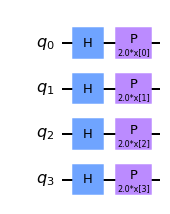

In [7]:
feature_map = feature_map
feature_map.decompose().draw(output="mpl", fold=20)

The implementation `PegasosQSVC` is compatible with the `scikit-learn` interfaces. In the constructor we pass parameters of the algorithm: the regularization hyper-parameter $C$ and the number of steps.

Then we pass training features and labels to the `fit` method, which trains a models and returns a fitted classifier. And finally we score our model using test features and labels.

In [8]:
from qiskit_machine_learning.algorithms import PegasosQSVC
import time

pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

# training
start = time.time()
pegasos_qsvc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

# testing
start = time.time()
pegasos_score = pegasos_qsvc.score(test_features, test_labels)
elapsed = time.time() - start

print(f"Testing time: {round(elapsed)} seconds")
print(f"PegasosQSVC classification test score: {pegasos_score}")

Training time: 7 seconds
Testing time: 889 seconds
PegasosQSVC classification test score: 0.6075137446548564


Now we plot the confussion matrices. First, with the train data

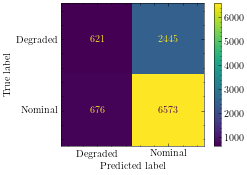

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

labels_predict_train = pegasos_qsvc.predict(train_features)

#matriz de confusion
cm = confusion_matrix(train_labels, labels_predict_train, labels=[0, 1])

# plot de matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Degraded', 'Nominal'])

disp.plot()
plt.show()

# Save Confussion Matrix
name = "QSVC_ZFeatureMap_FidelityQuantumKernel_TRAIN"
plt.savefig("./outputs/QSVC/CMAPSS/SENSOR/"+name+".pdf", format='pdf', bbox_inches='tight')

Then, with the test data.

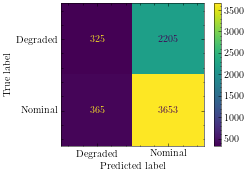

In [10]:
labels_predict_test = pegasos_qsvc.predict(test_features)

#matriz de confusion
cm = confusion_matrix(test_labels, labels_predict_test, labels=[0, 1])

# plot de matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Degraded', 'Nominal'])

disp.plot()
plt.show()

# Save Confussion Matrix
name = "QSVC_ZFeatureMap_FidelityQuantumKernel_TEST"
plt.savefig("./outputs/QSVC/CMAPSS/SENSOR/"+name+".pdf", format='pdf', bbox_inches='tight')

Then we define a function to calculate more evaluation metrics and calculate all of this metrics among the accuracies prevoiusly obtained.

In [11]:
def metrics(matrix):
    TP = matrix[0, 0]
    FP = matrix[0, 1]
    FN = matrix[1, 0]
    TN = matrix[1, 1]
    # Metrics calculation
    total = TP + FP + FN + TN
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    npv = TN / (TN + FN)

    # Print the results
    print(f"Precision: {precision:.2f}\nRecall: {recall:.2f}\nSpecificity: {specificity:.2f}\nNPV: {npv:.2f}")

train_score_q4 = pegasos_qsvc.score(train_features, train_labels)
test_score_q4 = pegasos_qsvc.score(test_features, test_labels)

print("Quantum VQC on the training dataset:")
print(f"Accuracy: {train_score_q4:.2f}")
metrics(cm_train)
print("\nQuantum VQC on the test dataset:")
print(f"Accuracy: {test_score_q4:.2f}")
metrics(cm_test)

Quantum VQC on the training dataset:
Accuracy: 0.70
Precision: 0.20
Recall: 0.48
Specificity: 0.73
NPV: 0.91

Quantum VQC on the test dataset:
Accuracy: 0.61
Precision: 0.13
Recall: 0.47
Specificity: 0.62
NPV: 0.91
